In [1]:

from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

load_dotenv()

True

In [2]:
class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools=tools)

In [4]:
def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
    }

def tools_router(state: ChildState):
    last_message = state["messages"][-1]

    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tool_node"
    else:
        return END

In [5]:
tool_node = ToolNode(tools=tools)

subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent", tools_router)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

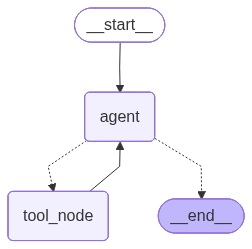

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [7]:
search_app.invoke({"messages": [HumanMessage(content="Tell me about netflix aquisition of warner brothers")]})


{'messages': [HumanMessage(content='Tell me about netflix aquisition of warner brothers', additional_kwargs={}, response_metadata={}, id='01547056-76a0-4c1a-ad03-7fb47561d216'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7a05rvest', 'function': {'arguments': '{"query":"Netflix acquisition of Warner Brothers"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 289, 'total_tokens': 311, 'completion_time': 0.039416844, 'prompt_time': 0.017693222, 'queue_time': 0.053204608, 'total_time': 0.057110066}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f188f38-7cea-480a-891f-dd618cb554fa-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Netflix acquisition of Warner Brothers'}, 'id': '7a05rvest', 'type': 'tool_call'}], usage_metadata={'input_tokens': 289, 'output_tokens': 

## 1. Parent Node and Child node has same schema

In [8]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_core.messages import HumanMessage

class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

parent_graph = StateGraph(ParentState)

# Add the subgraph as a node
parent_graph.add_node("search_agent", search_app)

parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

parent_app = parent_graph.compile()

result = parent_app.invoke({"messages": [HumanMessage(content="Tell me about netflix aquisition of warner brothers")]})
result

{'messages': [HumanMessage(content='Tell me about netflix aquisition of warner brothers', additional_kwargs={}, response_metadata={}, id='94d9b6f6-1b54-4825-beec-446238514605'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'p4pngnysr', 'function': {'arguments': '{"query":"netflix acquisition of warner brothers"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 289, 'total_tokens': 313, 'completion_time': 0.032238262, 'prompt_time': 0.020339896, 'queue_time': 0.049861924, 'total_time': 0.052578158}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-55288360-ea9f-46de-82d8-8f68f63e081c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'netflix acquisition of warner brothers'}, 'id': 'p4pngnysr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 289, 'output_tokens': 

## 2. Parent and child has different schema

In [9]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

class QueryState(TypedDict):
    query: str
    response: str

# Function to invoke subgraph
def search_agent(state: QueryState) -> Dict:
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }

    subgraph_result = search_app.invoke(subgraph_input)

    # Transform response back to parent schema
    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}

parent_graph = StateGraph(QueryState)

parent_graph.add_node("search_agent", search_agent)

parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

parent_app = parent_graph.compile()

result = parent_app.invoke({"query": "Tell me about netflix aquisition of warner brothers", "response": ""})
print(result)


{'query': 'Tell me about netflix aquisition of warner brothers', 'response': 'The current information available suggests that Netflix has acquired Warner Brothers, including its film and television studios, HBO Max and HBO. The acquisition brings together two pioneering entertainment businesses, combining Netflix\'s innovation, global reach, and best-in-class streaming service with Warner Bros.\' century-long legacy of world-class storytelling. The deal includes beloved franchises, shows, and movies such as "The Big Bang Theory," "The Sopranos," "Game of Thrones," and the DC Universe, which will join Netflix\'s extensive portfolio. The acquisition is expected to create more opportunities for the creative community and generate shareholder value.'}
